Here I try to recreate all the function in the R files (estimator, filter and simulator) in the Python language to check if I have really understood the topic.

In [306]:
import math
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import scipy.stats as stats
import scipy.special as sp


In [179]:
def martingale_diff(y, mu_t, varsigma, nu):
    u_t = ((1 / (1 + (y - mu_t)**2)/(nu*varsigma)) * (y - mu_t))

    return u_t

In [317]:
def uSTD_uDCS_t(y, mu_t, varsigma, nu, log):
    ulpdf = (sp.gammaln((nu + 1) / 2) - sp.gammaln(nu / 2) - (1/2) * math.log(varsigma) -
              (1/2)  * math.log(math.pi * nu) - ((nu + 1) / 2) * math.log(1 + (y - mu_t)** 2 / (nu*varsigma) ))
    if (log != True):
        ulpdf = math.exp(ulpdf)
        
    return ulpdf

In [333]:
def uDCS_t_model_filter (y, theta):
    
    n = len(y)

    dloglik = np.zeros(n)
    loglik = float()

    omega = theta[0]
    phi = theta[1]
    k = theta[2]
    varsigma = theta[3]
    nu = theta[4]

    mu_t = np.full(n+1, np.nan)
    u_t = np.full(n, np.nan)

    mu_t[0] = omega
    dloglik[0] = uSTD_uDCS_t(y[0], mu_t=mu_t[0], varsigma=varsigma, nu=nu, log=True)

    

    for t in range (1, n + 2):
        u_t[t-1] = martingale_diff(y[t-1], mu_t[t-1], varsigma, nu)
        mu_t[t] = omega + phi * (mu_t[t-1]- omega) + k * u_t[t-1]

        if t < n + 1:
            dloglik[t] = uSTD_uDCS_t(y[t], mu_t=mu_t[t], varsigma=varsigma, nu=nu, log=True)
            loglik += dloglik[t]

    mu_t = np.array([np.nan] * (n+1))
    u_t = np.array([np.nan] * n)

    out = {'Dynamic Location': mu_t,
           'Innovation': u_t,
           'Log_Densities_i': dloglik,
           'Log_Likelihood' : loglik
    }

    return out
    


In [182]:
def uSTDT_rnd (n, mu, varsigma, nu):
    z = stats.t.rvs(df=nu, size=n)
    y = np.empty(n)
    for i in range(0, n):
        y[i] = mu + z[i]* np.sqrt(varsigma)
    
    return y
    

In [238]:
def uDCS_t_model_simulator (T, omega, phi, k, varsigma, nu):

    y = np.full(T, np.nan)
    mu_t = np.full(T, np.nan)
    u_t = np.full(T, np.nan)
    v = np.full(T, np.nan)

    mu_t[0] = omega

    y[0] = uSTDT_rnd(1, mu_t[0], varsigma, nu)
    print(y[0])

    for t in range(1, T):

        u_t[t-1] = martingale_diff(y[t-1], mu_t[t-1], varsigma, nu)
        mu_t[t] = omega + phi * (mu_t[t-1] - omega) + k * u_t[t-1]
        y[t] = uSTDT_rnd(1, mu_t[t], varsigma, nu)
        v[t] = y[t]-mu_t[t]

    out = {
        'y_t_gen': np.array(y),
        'Dynamic_Location': np.array(mu_t),
        'Innovation_u_t': np.array(u_t),
        'Prediction error' : np.array(v)
    }

    return out

In [297]:
def interprete_uDCS_t_model (data, param):
    n = len(data)

    omega = param[0]
    phi = param[1]
    k = param[2]

    varsigma = param[3]
    nu = param[4]

    theta_new = [omega, phi, k, varsigma, nu]

    fitness = uDCS_t_model_filter(data, theta_new)['Log-Likelihood']
    
    if np.isnan(fitness) or not np.isfinite(fitness):
        fitness = -1e10
    
    return fitness



In [295]:
def uDCS_t_model_estimator (data, param):

    T = len(data)

    omega = param[0]
    phi = param[1]
    k = param[2]

    varsigma = param[3]
    nu = param[4]

    theta_st = [omega, phi, k, varsigma, nu]

    lower =[-np.inf, -0.999, -2, 1e-05, 2.099]
    upper =[ np.inf,  0.999,  2, np.inf, 300]

    optimizer = minimize(fun=interprete_uDCS_t_model, x0=theta_st, args=(data,), method='L-BFGS-B', bounds=list(zip(lower, upper)), options={'disp': True})

# Save the optimized parameters Dynamic Location
    omega_opt = optimizer.x[0]
    phi_opt = optimizer.x[1]
    k_opt = optimizer.x[2]

    varsigma_opt = optimizer.x[3]
    nu_opt = optimizer.x[4]

# Create a vector with ALL the optimized parameters
    theta_opt = np.array([omega_opt, phi_opt, k_opt, varsigma_opt, nu_opt])

# Create a dictionary with ALL the optimized parameters
    theta_dict = {
        'omega': omega_opt,
        'phi': phi_opt,
        'k': k_opt,
        'varsigma': varsigma_opt,
        'nu': nu_opt
    }   

    out = {
    'theta_list': theta_dict,
    'theta': theta_opt,
    'optimizer': optimizer
    }

    return out

-0.503822476586312


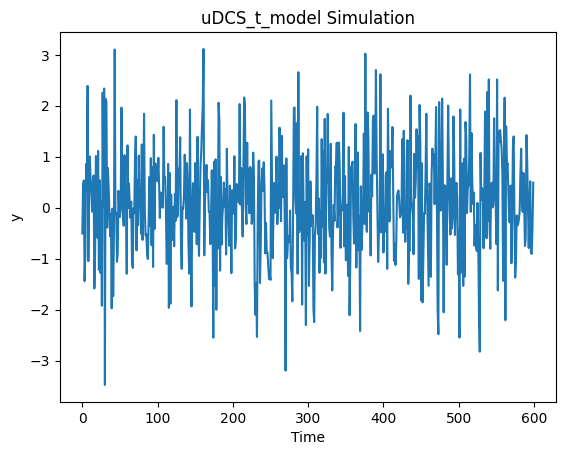

In [290]:
T = 600
omega = 0
phi = 0.8
k = 0.8
varsigma = 1
nu = 40

theta = [omega, phi, k ,varsigma, nu]

simu = uDCS_t_model_simulator(T, omega, phi, k ,varsigma, nu)

y = simu['y_t_gen']


# Plot the time series
plt.plot(y)
plt.xlabel('Time')
plt.ylabel('y')
plt.title('uDCS_t_model Simulation')
plt.show()


Plot ut against yt for ν = 3, 10, 200. Comment the results in terms of response of the score to extreme observations

In [334]:
T = 600
omega = 0
phi = 0.8
k = 1
varsigma = 1
theta = [T, omega, phi, k, varsigma]

nu_values = [3, 10, 200]

for nu in nu_values:
    simu = uDCS_t_model_simulator(T, omega, phi, k, varsigma, nu)
    filt = uDCS_t_model_filter(y, theta)
    y = simu['y_t_gen']
    mart = martingale_diff(y, filt['mu_t'], varsigma, nu)
    u = mart['u_t']
    
    plt.scatter(y, u)
    plt.xlabel('y_t')
    plt.ylabel('u_t')
    plt.title('ν = ' + str(nu))
    plt.xlim([-4,4])
    plt.ylim([-.25,.25])
    min_value = min(np.min(y), np.min(u))
    max_value = max(np.max(y), np.max(u))
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')
    plt.show()

fig, ax = plt.subplots()
plt.xlabel('y_t')
plt.ylabel('u_t')

def update_plot(nu):
    ax.clear()
    simu = uDCS_t_model_simulator(T, omega, phi, k, varsigma, nu)
    y = simu['y_t_gen']
    u = simu['Innovation_u_t']
    
    ax.scatter(y, u)
    ax.set_title('ν = ' + str(nu))
    plt.xlabel('y_t')
    plt.ylabel('u_t')
    display(fig)

slider = widgets.IntSlider(min=3, max=200, step=10, description='ν:', value=3)
widgets.interactive(update_plot, nu=slider)

-0.01507895373598142


IndexError: index 600 is out of bounds for axis 0 with size 600

simulate a DCS-t-location model with parameters specified as you choose and

(a) plot the series

(b) plot the time varying parameter

(c) plot ut and vt

(d) plot the autocorrelation of yt
, ut and vt

(e) if you want, estimate the model (you can use the file uploaded on Virtuale)
Comment the results.

a) plot the series

-0.25995389128470037


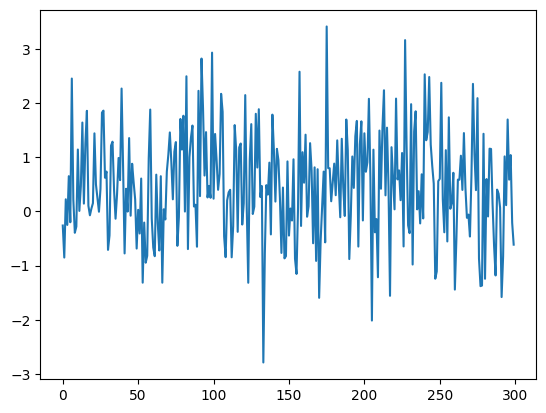

In [265]:
T = 300
omega = 0.5
phi = 0.5
k = 0.5
varsigma = 1
nu = 24
result = uDCS_t_model_simulator(T, omega, phi, k, varsigma, nu)
y = result['y_t_gen']
plt.plot(y)


b) plot the time varying parameter

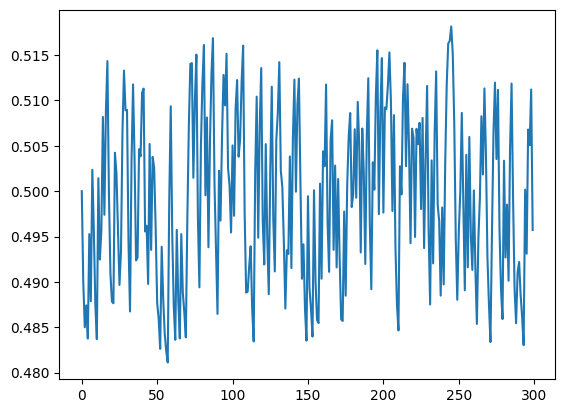

In [291]:
mu = result['Dynamic_Location']
plt.plot(mu)

c) plot u_t and v_t

In [298]:
omega = 0
phi = 0.8
k = 0.8
varsigma = 1
nu = 8

theta = np.array([omega, phi, k, varsigma, nu])

# Estimate the parameters (uses functions in Estimator)
# Input: data, y, and INITIAL parameter values, theta
est = uDCS_t_model_estimator(y, theta)
theta_list = est['theta_list']

# Recover the estimated time-varying signal (uses functions in Filter)
# Input: data, y, and ESTIMATED parameter values, theta
filter_result = uDCS_t_model_filter(y, est['theta'])
y_estimated = filter_result['Dynamic_Location']

# Plot the original data and the estimated time-varying signal
plt.plot(y)
plt.plot(y_estimated, color='red')
plt.xlabel('Time')
plt.ylabel('Signal')
plt.legend(['Original', 'Estimated'])
plt.show()

# Compare the estimated one-step-ahead prediction error with the score
# Both are mds, the score is nonlinear and robust if nu is small,
# if nu -> infinity, then the score u_t converges to the one-step-ahead prediction error
# which is then linear and Gaussian

T = len(y)
v = np.zeros(T)
for t in range(1, T+1):
    v[t-1] = y[t-1] - filter_result['Dynamic_Location'][t-1]

# Plot of the innovation error v_t against the robust score u_t
plt.plot(v)
plt.plot(filter_result['Innovation_u_t'], color='green')
plt.xlabel('Time')
plt.ylabel('Error')
plt.legend(['Innovation Error', 'Robust Score'])
plt.show()

NameError: name 'n' is not defined

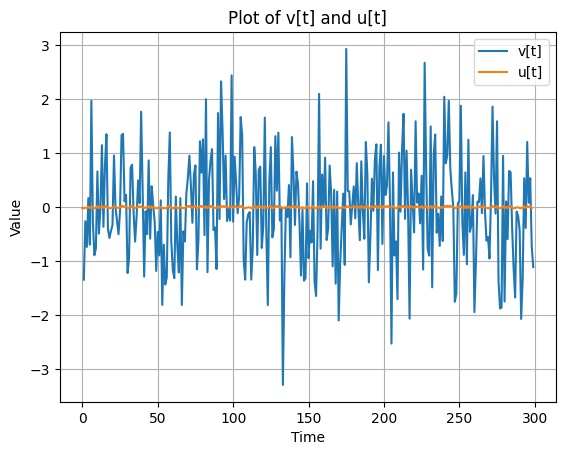

In [267]:
u = result['Innovation_u_t']
v = result['Prediction error']
plt.plot( v, label='v[t]')
plt.plot( u, label='u[t]')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Plot of v[t] and u[t]')
plt.legend()
plt.grid(True)
plt.show()


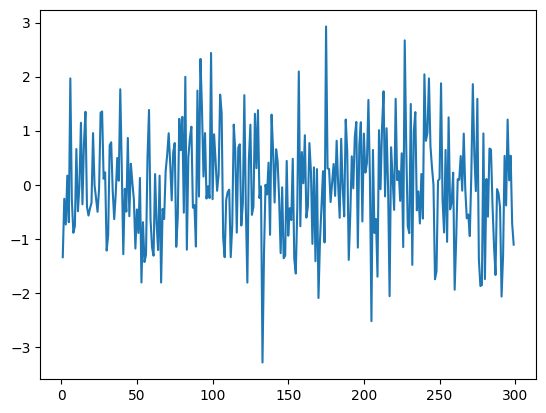

In [268]:
v = result['Prediction error']
plt.plot(v)

In [274]:
y = result['y_t_gen']
y

array([-2.59953891e-01, -8.51465592e-01,  2.24060018e-01, -2.48892214e-01,
        6.50895409e-01, -1.99692855e-01,  2.45410312e+00,  2.18609398e-01,
       -3.94045267e-01, -2.79229210e-01,  1.14323252e+00,  9.85194394e-03,
        4.67327340e-01,  1.64135015e+00,  1.44595003e-01,  1.25859287e+00,
        1.85780195e+00,  1.05144475e-01, -7.13671202e-02,  5.32107107e-02,
        1.53186680e-01,  1.44202277e+00,  4.98275575e-01,  2.48627234e-01,
       -5.60774716e-03,  4.16307994e-01,  1.82544913e+00,  1.86157415e+00,
        6.23061453e-01,  7.36212371e-01, -7.09840543e-01, -4.40986840e-01,
        1.21525294e+00,  1.28804395e+00,  4.02437969e-01, -1.34226909e-01,
        3.20103739e-01,  9.87007428e-01,  5.78211310e-01,  2.26932514e+00,
        8.19958248e-01, -7.75397240e-01,  4.18727674e-01, -2.72174960e-03,
        1.35462819e+00, -7.87644074e-02,  8.80205273e-01,  5.37146177e-01,
        2.23726292e-01, -6.85479410e-01,  2.95873320e-02, -4.07514067e-01,
        6.07394672e-01, -

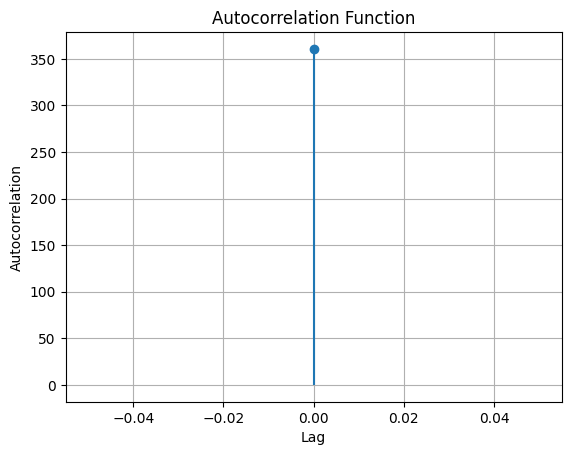

In [277]:
y = result['y_t_gen']
autocorr_y = np.correlate(y,y)
plt.stem(autocorr_y)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_base.py:2532: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


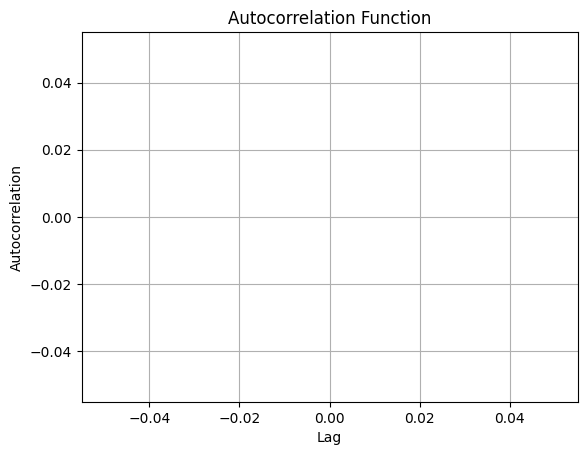

In [278]:
v = result['Innovation_u_t']
autocorr_v = np.correlate(v,v)
plt.stem(autocorr_v)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()

ValueError: could not broadcast input array from shape (300,) into shape (599,)

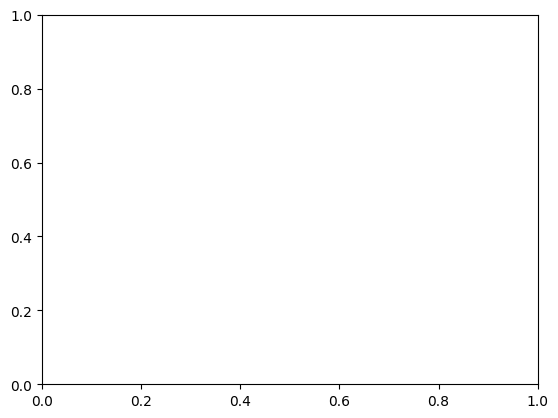

In [286]:
u = result['Innovation_u_t']
autocorr_u = np.correlate(u, u, mode='full') / len(u)
lags = np.arange(-len(u) + 1, len(u))


# Crop the autocorrelation array
center = len(lags) // 2
autocorr_u = autocorr_u[center:center + len(lags)]
plt.stem(lags, autocorr_u)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function')
plt.grid(True)
plt.show()